# Heart Disease Prediction using Neural Networks 

In [232]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import plotly.express as px
import wfdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.signal import find_peaks

In [243]:
nrows=None # number of patients to load, set to None to load all patients
path="./"
sampling_rate=100

### 1. Importing the Dataset

The dataset is available through the University of California, Irvine Machine learning repository. Here is the URL:

http:////archive.ics.uci.edu/ml/datasets/Heart+Disease

This dataset contains patient data concerning heart disease diagnosis that was collected at several locations around the world. There are 76 attributes, including age, sex, resting blood pressure, cholestoral levels, echocardiogram data, exercise habits, and many others. To data, all published studies using this data focus on a subset of 14 attributes - so we will do the same. More specifically, we will use the data collected at the Cleveland Clinic Foundation.

To import the necessary data, we will use pandas' built in read_csv() function. Let's get started!

## Add HRV metrics to dataframe

In [244]:


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# HRV calculation function (based on RR intervals)
def calculate_hrv(ecg_signal, sampling_rate):
    # Assuming the ECG signal is one-dimensional
    ecg = ecg_signal.flatten()

    # Find R-peaks using a simple peak detection (find local maxima)
    peaks, _ = find_peaks(ecg, distance=sampling_rate//2)  # Assume at least 0.5 sec between R peaks
    rr_intervals = np.diff(peaks) / sampling_rate * 1000  # RR intervals in milliseconds

    # Calculate HRV statistics
    if len(rr_intervals) > 1:
        hrv_mean = np.mean(rr_intervals)
        hrv_std = np.std(rr_intervals)
        hrv_min = np.min(rr_intervals)
        hrv_max = np.max(rr_intervals)
    else:
        # If only one RR interval, return NaN for std, min, max
        hrv_mean = np.mean(rr_intervals) if len(rr_intervals) > 0 else np.nan
        hrv_std = np.nan
        hrv_min = np.nan
        hrv_max = np.nan

    return hrv_mean, hrv_std, hrv_min, hrv_max

def add_hrv_features(df, X, sampling_rate):
    # Add columns for HRV mean, std, min, max to the dataframe
    hrv_means = []
    hrv_stds = []
    hrv_mins = []
    hrv_maxs = []

    for idx, signal in enumerate(X):
        hrv_mean, hrv_std, hrv_min, hrv_max = calculate_hrv(signal, sampling_rate)
        hrv_means.append(hrv_mean)
        hrv_stds.append(hrv_std)
        hrv_mins.append(hrv_min)
        hrv_maxs.append(hrv_max)

    df['hrv_mean'] = hrv_means
    df['hrv_std'] = hrv_stds
    df['hrv_min'] = hrv_mins
    df['hrv_max'] = hrv_maxs

    return df

# Load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id', nrows=nrows)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Add HRV features to the DataFrame
Y = add_hrv_features(Y, X, sampling_rate)

database_row = Y
database_row.tail()


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,hrv_mean,hrv_std,hrv_min,hrv_max
ecg_id,,,,,,,,,,,,,,,,,,,,,
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr,663.222222,137.601096,500.0,1010.0
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr,671.292135,150.445085,500.0,1010.0
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr,648.913043,124.284531,500.0,1010.0
21836,8873.0,64.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-09 18:21:49,supraventrikulÄre extrasystole(n) sinusrhythmu...,...,NaN,SVES,NaN,8,records100/21000/21836_lr,records500/21000/21836_hr,649.673913,132.167969,500.0,1000.0
21837,11744.0,68.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-11 16:43:01,sinusrhythmus p-sinistrocardiale lagetyp norma...,...,NaN,NaN,NaN,9,records100/21000/21837_lr,records500/21000/21837_hr,664.222222,137.197974,500.0,1050.0


In [245]:
# print the last twenty or so data points
print(database_row.columns)
database_row.loc[301]

Index(['patient_id', 'age', 'sex', 'height', 'weight', 'nurse', 'site',
       'device', 'recording_date', 'report', 'scp_codes', 'heart_axis',
       'infarction_stadium1', 'infarction_stadium2', 'validated_by',
       'second_opinion', 'initial_autogenerated_report', 'validated_by_human',
       'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems',
       'extra_beats', 'pacemaker', 'strat_fold', 'filename_lr', 'filename_hr',
       'hrv_mean', 'hrv_std', 'hrv_min', 'hrv_max'],
      dtype='object')


patient_id                                          3830.0
age                                                   60.0
sex                                                      0
height                                               183.0
weight                                                85.0
nurse                                                  6.0
site                                                   1.0
device                                          AT-6 C 5.5
recording_date                         1986-09-12 18:14:21
report                           sinus rhythm. normal ecg.
scp_codes                       {'NORM': 100.0, 'SR': 0.0}
heart_axis                                             NaN
infarction_stadium1                                    NaN
infarction_stadium2                                    NaN
validated_by                                           0.0
second_opinion                                       False
initial_autogenerated_report                         Fal

In [250]:

# remove missing data (indicated with a "?")
# data = cleveland[~cleveland.isin(['?'])]
df = database_row[['age',
        'sex',
        'height',
        'weight',
        'device',
        'scp_codes',
        'hrv_mean',
        'hrv_std',
        'hrv_min',
        'hrv_max'
]]
df.describe()

,age,sex,height,weight,hrv_mean,hrv_std,hrv_min,hrv_max
count,21799.000000,21799.000000,6974.000000,9421.000000,21799.000000,21799.000000,21799.000000,21799.000000
mean,62.769301,0.479150,166.702323,70.995223,649.039740,125.113459,500.490389,1005.541997
std,32.308813,0.499577,10.867321,15.878803,13.780248,10.852530,2.203703,22.101256
min,2.000000,0.000000,6.000000,5.000000,596.400000,61.101471,500.000000,850.000000
25%,50.000000,0.000000,160.000000,60.000000,639.839572,118.458252,500.000000,990.000000
50%,62.000000,0.000000,166.000000,70.000000,648.858696,125.839795,500.000000,1010.000000
75%,72.000000,1.000000,174.000000,80.000000,658.186813,132.512284,500.000000,1020.000000
max,300.000000,1.000000,209.000000,250.000000,703.764706,166.743934,530.000000,1090.000000


### Remove outliers

In [ ]:

for col in ['age', 'sex', 'height', 'weight']:

    q_low = df[col].quantile(0.01)
    q_hi  = df[col].quantile(0.99)

    df_filtered = df[(df[col] < q_hi) & (df[col] > q_low)]

df = df_filtered.copy()
df = df[df['age'] < 100] 
df

,age,sex,height,weight,device,scp_codes,hrv_mean,hrv_std,hrv_min,hrv_max
ecg_id,,,,,,,,,,
1,56.0,1,NaN,63.0,CS-12 E,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",651.195652,128.961929,500.0,1000.0
2,19.0,0,NaN,70.0,CS-12 E,"{'NORM': 80.0, 'SBRAD': 0.0}",648.913043,121.672730,500.0,970.0
3,37.0,1,NaN,69.0,CS-12 E,"{'NORM': 100.0, 'SR': 0.0}",670.505618,132.071961,500.0,1000.0
4,24.0,0,NaN,82.0,CS-12 E,"{'NORM': 100.0, 'SR': 0.0}",648.054054,116.746421,500.0,1050.0
5,19.0,1,NaN,70.0,CS-12 E,"{'NORM': 100.0, 'SR': 0.0}",647.065217,134.681896,500.0,1000.0
...,...,...,...,...,...,...,...,...,...,...
20970,58.0,0,168.0,74.0,AT-60 3,"{'ASMI': 100.0, 'ISCAL': 100.0, 'ABQRS': 0.0, ...",624.062500,107.757232,500.0,1030.0
21040,58.0,0,168.0,74.0,AT-60 3,"{'ASMI': 100.0, 'ISCAL': 100.0, '1AVB': 100.0,...",634.603175,127.774919,500.0,1030.0
21106,47.0,1,160.0,50.0,AT-60 3,"{'NORM': 100.0, 'SR': 0.0}",641.390374,130.159066,500.0,980.0


### BMI Calculation

In [252]:
df.loc[:, "BMI"] = df["weight"] / (df["height"] / 100)**2
df.loc[301]

age                                60.0
sex                                   0
height                            183.0
weight                             85.0
device                       AT-6 C 5.5
scp_codes    {'NORM': 100.0, 'SR': 0.0}
hrv_mean                     636.010638
hrv_std                      116.013297
hrv_min                           500.0
hrv_max                           970.0
BMI                           25.381469
Name: 301, dtype: object

## SCP codes expansion for future visualization

In [253]:
# Expand the scp_codes into separate rows for each condition
expanded_rows = []

for _, row in df.iterrows():
    for condition, value in row['scp_codes'].items():
        if value > 0:  # Include only non-zero conditions
            new_row = row.to_dict()  # Convert the row to a dictionary
            new_row['Class'] = condition  # Set the class to the condition name
            new_row['Confidence'] = value  # Set the confidence level
            expanded_rows.append(new_row)  # Append the new row

# Create a new DataFrame with the expanded rows
expanded_df = pd.DataFrame(expanded_rows)

# Drop the original 'scp_codes' column as it's no longer needed
expanded_df = expanded_df.drop(columns=['scp_codes'])

expanded_df

,age,sex,height,weight,device,hrv_mean,hrv_std,hrv_min,hrv_max,BMI,Class,Confidence
0,56.0,1,NaN,63.0,CS-12 E,651.195652,128.961929,500.0,1000.0,NaN,NORM,100.0
1,19.0,0,NaN,70.0,CS-12 E,648.913043,121.672730,500.0,970.0,NaN,NORM,80.0
2,37.0,1,NaN,69.0,CS-12 E,670.505618,132.071961,500.0,1000.0,NaN,NORM,100.0
3,24.0,0,NaN,82.0,CS-12 E,648.054054,116.746421,500.0,1050.0,NaN,NORM,100.0
4,19.0,1,NaN,70.0,CS-12 E,647.065217,134.681896,500.0,1000.0,NaN,NORM,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...
12297,58.0,0,168.0,74.0,AT-60 3,634.603175,127.774919,500.0,1030.0,26.218821,ISCAL,100.0
12298,58.0,0,168.0,74.0,AT-60 3,634.603175,127.774919,500.0,1030.0,26.218821,1AVB,100.0
12299,47.0,1,160.0,50.0,AT-60 3,641.390374,130.159066,500.0,980.0,19.531250,NORM,100.0
12300,58.0,1,NaN,52.0,CS100 3,665.944444,143.784937,500.0,1020.0,NaN,IRBBB,100.0


In [257]:
# Define the key heart disease classes to focus on
key_classes = ['ISC_', 'NORM']  # Adjust this list based on relevance

# Filter the expanded DataFrame to keep only the selected classes
filtered_df = expanded_df[expanded_df['Class'].isin(key_classes)]

# Separate out the "NORM" class for comparison
norm_df = filtered_df[filtered_df['Class'] == 'NORM']

# Loop through each selected class and compare it to "NORM"
for current_class in key_classes:
    if current_class == 'NORM':  # Skip "NORM" itself
        continue
    
    # Filter for the current class to compare with "NORM"
    class_df = filtered_df[filtered_df['Class'] == current_class]
    
    # Combine norm_df and class_df for plotting
    compare_df = pd.concat([norm_df, class_df])
    
    # Generate scatter plots for chosen feature pairs
    for x_axis_data, y_axis_data in [('BMI', 'age'), ('hrv_mean', 'age')]:
        title = f"Comparison of '{current_class}' vs 'NORM' ({x_axis_data} vs {y_axis_data})"
        fig = px.scatter(
            compare_df, x=x_axis_data, y=y_axis_data, color='Class',
            title=title
        )
        fig.show()


In [ ]:
#@title Plot three features in 3D by entering their names and running this cell

x_axis_data = 'age'  # @param {type: "string"}
y_axis_data = 'BMI'  # @param {type: "string"}
z_axis_data = 'Confidence'  # @param {type: "string"}

class_df = expanded_df[(expanded_df['Class'] == "NORM") | (expanded_df["Class"] == "ISC_")]

px.scatter_3d(
    class_df,
    x=x_axis_data,
    y=y_axis_data,
    z=z_axis_data,
    color='Class',
).show()

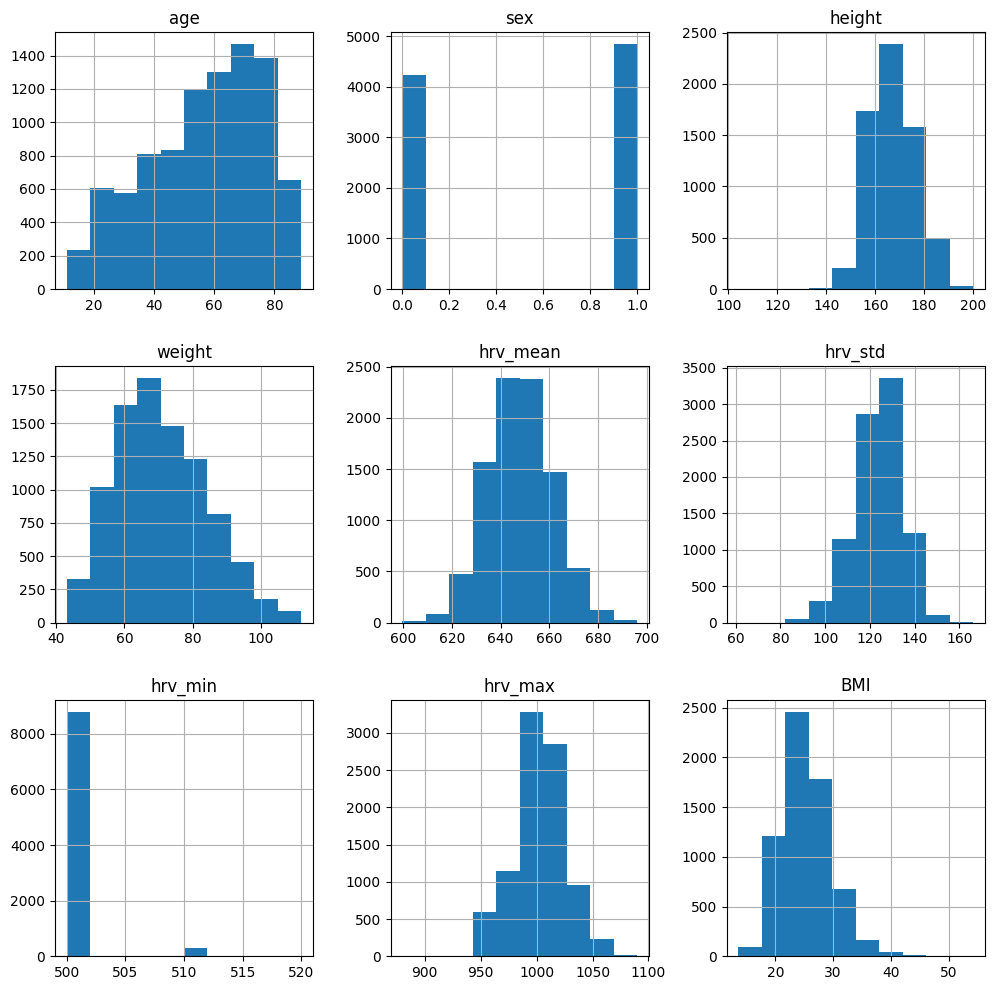

In [259]:
# plot histograms for each variable
df.hist(figsize = (12, 12))
plt.show()

### Data normalization

In [260]:
from tensorflow import keras

keras.utils.set_random_seed(42)

In [261]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

columns = ["age", "weight", "height", "BMI", "Confidence", 'hrv_mean', 'hrv_std', 'hrv_min', 'hrv_max']

feature_mean = expanded_df[columns].mean()
feature_std = expanded_df[columns].std()
numerical_features = expanded_df.select_dtypes('number').columns.drop('sex')
normalized_dataset = (
    expanded_df[numerical_features] - feature_mean
) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Class'] = expanded_df['Class']

# Examine some of the values of the normalized training set. Notice that most
# Z-scores fall between -2 and +2.
normalized_dataset.tail()

,BMI,Confidence,age,height,hrv_max,hrv_mean,hrv_min,hrv_std,weight,Class
12297,0.259769,0.493349,-0.121893,0.094610,1.317428,-0.954007,-0.17488,0.434105,0.255730,ISCAL
12298,0.259769,0.493349,-0.121893,0.094610,1.317428,-0.954007,-0.17488,0.434105,0.255730,1AVB
12299,-1.309003,0.493349,-0.708376,-0.722333,-1.022190,-0.445055,-0.17488,0.654461,-1.508005,NORM
12300,NaN,0.493349,-0.121893,NaN,0.849505,1.396181,-0.17488,1.913842,-1.361027,IRBBB
12301,2.171385,0.493349,-0.175210,0.094610,0.381581,-0.327579,-0.17488,0.621539,1.945976,NORM


In [262]:
# Create a column setting the Norm label to '1' and the Osmancik label to '0'
# then show 10 randomly selected rows.
normalized_dataset['Class_Bool'] = (
    # Returns true if class is Norm, and false if other heart desease
    normalized_dataset['Class'] == 'NORM'
).astype(int)
normalized_dataset.sample(10)

,BMI,Confidence,age,height,hrv_max,hrv_mean,hrv_min,hrv_std,weight,Class,Class_Bool
10711,-1.141595,-1.708164,1.477606,0.809435,-1.022190,-0.255011,-0.17488,-1.254403,-0.626138,ISC_,0
7496,-0.103307,0.493349,0.837806,-1.539277,0.381581,2.145133,-0.17488,1.757035,-0.993582,NST_,0
7841,0.359413,0.493349,0.517906,0.298846,-0.554266,-0.752737,-0.17488,-0.686483,0.476197,NST_,0
5714,1.160085,0.493349,0.144690,0.707318,0.849505,-1.228145,-0.17488,-0.052556,1.505042,NORM,1
6181,-0.054485,0.493349,-0.121893,2.034850,0.381581,1.528537,-0.17488,0.881715,1.211086,NORM,1
11024,1.511216,0.493349,1.211023,-0.007508,0.849505,-0.537285,-0.17488,0.398954,1.284575,NDT,0
8688,0.176655,0.493349,0.624540,0.094610,-0.086343,0.078293,-0.17488,0.793166,0.182241,NDT,0
8318,-0.002801,0.493349,-0.655060,-0.007508,-1.958037,-0.720828,-0.17488,-1.282055,-0.038226,ISCAL,0
9682,-0.315518,0.493349,0.891123,2.136968,-0.086343,-1.000035,-0.17488,0.536277,0.990619,IRBBB,0
9285,-0.252604,-3.249223,1.157706,-0.926569,-0.086343,0.765017,-0.17488,-0.443086,-0.773116,IMI,0


We can then randomize and partition the dataset into train, test, and validation splits, consisting of 80%, 10%, and 10% of the dataset respectively.

In [263]:
# Create indices at the 80th and 90th percentiles
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

# Show the first five rows of the last split
test_data.head()

,BMI,Confidence,age,height,hrv_max,hrv_mean,hrv_min,hrv_std,weight,Class,Class_Bool
11438,-0.168988,0.493349,1.104389,0.605200,-1.958037,-1.475856,-0.17488,-2.064935,0.182241,LPFB,0
10706,NaN,0.493349,-0.228526,NaN,-0.086343,-0.026433,-0.17488,-0.835886,0.329219,NORM,1
4631,-1.321694,0.493349,1.051073,-1.539277,-0.086343,0.513687,-0.17488,0.265611,-1.875450,ISCAS,0
4532,-0.404125,-0.387256,-0.228526,0.605200,-1.958037,-1.124612,-0.17488,-1.062486,-0.038226,NORM,1
7950,NaN,0.493349,-2.094609,NaN,-0.086343,0.180178,-0.17488,0.075281,-0.846605,NDT,0


It's important to prevent the model from getting the label as input during training, which is called label leakage. This can be done by storing features and labels as separate variables.

In [264]:
label_columns = ['Class', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

## Train and compare the models

In [294]:
# Name of the features we'll train our model on.
input_features = ["age"]

In [287]:
# @title Define the functions that create and train a model.

import dataclasses


@dataclasses.dataclass()
class ExperimentSettings:
  """Lists the hyperparameters and input features used to train am model."""

  learning_rate: float
  number_epochs: int
  batch_size: int
  classification_threshold: float
  input_features: list[str]


@dataclasses.dataclass()
class Experiment:
  """Stores the settings used for a training run and the resulting model."""

  name: str
  settings: ExperimentSettings
  model: keras.Model
  epochs: np.ndarray
  metrics_history: keras.callbacks.History

  def get_final_metric_value(self, metric_name: str) -> float:
    """Gets the final value of the given metric for this experiment."""
    if metric_name not in self.metrics_history:
      raise ValueError(
          f'Unknown metric {metric_name}: available metrics are'
          f' {list(self.metrics_history.columns)}'
      )
    return self.metrics_history[metric_name].iloc[-1]


def create_model(
    settings: ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple classification model."""
  model_inputs = [
      keras.Input(name=feature, shape=(1,))
      for feature in settings.input_features
  ]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  dense = keras.layers.Dense(
      units=1, input_shape=(1,), name='dense_layer', activation=keras.activations.sigmoid
  )
  model_output = dense(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)
  # Call the compile method to transform the layers into a model that
  # Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ExperimentSettings,
) -> Experiment:
  """Feed a dataset into the model in order to train it."""

  # The x parameter of keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.
  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )


print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


In [288]:
# @title Define the plotting function.
def plot_experiment_metrics(experiment: Experiment, metrics: list[str]):
  """Plot a curve of one or more metrics for different epochs."""
  plt.figure(figsize=(12, 8))

  for metric in metrics:
    plt.plot(
        experiment.epochs, experiment.metrics_history[metric], label=metric
    )

  plt.xlabel("Epoch")
  plt.ylabel("Metric value")
  plt.grid()
  plt.legend()


print("Defined the plot_curve function.")

Defined the plot_curve function.


Epoch 1/60
99/99 [==============================] - 2s 3ms/step - loss: 0.6685 - accuracy: 0.4189 - precision: 0.4189 - recall: 1.0000 - auc: 0.7765
Epoch 2/60
99/99 [==============================] - 0s 2ms/step - loss: 0.6425 - accuracy: 0.4189 - precision: 0.4189 - recall: 1.0000 - auc: 0.7975
Epoch 3/60
99/99 [==============================] - 0s 3ms/step - loss: 0.6208 - accuracy: 0.4300 - precision: 0.4234 - recall: 0.9971 - auc: 0.8019
Epoch 4/60
99/99 [==============================] - 0s 2ms/step - loss: 0.6028 - accuracy: 0.5372 - precision: 0.4741 - recall: 0.9600 - auc: 0.8025
Epoch 5/60
99/99 [==============================] - 0s 2ms/step - loss: 0.5877 - accuracy: 0.6254 - precision: 0.5310 - recall: 0.9049 - auc: 0.8026
Epoch 6/60
99/99 [==============================] - 0s 2ms/step - loss: 0.5750 - accuracy: 0.6688 - precision: 0.5683 - recall: 0.8705 - auc: 0.8029
Epoch 7/60
99/99 [==============================] - 0s 2ms/step - loss: 0.5645 - accuracy: 0.6934 - precis

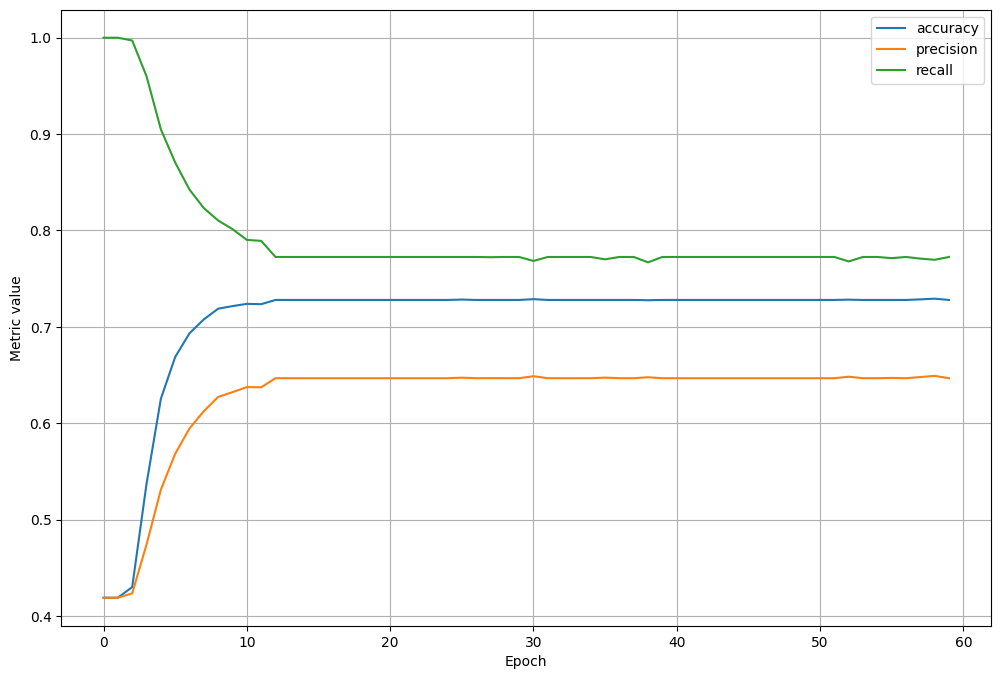

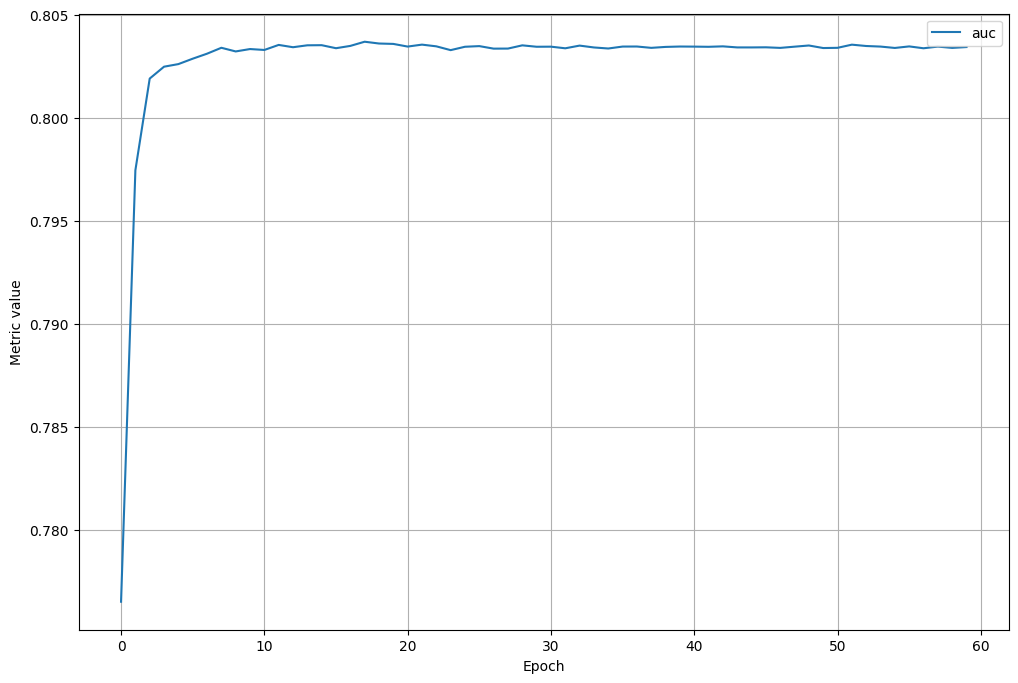

In [295]:
# Let's define our first experiment settings.
settings = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model = create_model(settings, metrics)

# Train the model on the training set.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Plot metrics vs. epochs
plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
plot_experiment_metrics(experiment, ['auc'])

In [296]:
def evaluate_experiment(
    experiment: Experiment, test_dataset: pd.DataFrame, test_labels: np.array
) -> dict[str, float]:
  features = {
      feature_name: np.array(test_dataset[feature_name])
      for feature_name in experiment.settings.input_features
  }
  return experiment.model.evaluate(
      x=features,
      y=test_labels,
      batch_size=settings.batch_size,
      verbose=0, # Hide progress bar
      return_dict=True,
  )


def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = evaluate_experiment(experiment, test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train loss: 0.5345
Test loss:  0.5399
------
Train accuracy: 0.7279
Test accuracy:  0.7089
------
Train precision: 0.6467
Test precision:  0.6200
------
Train recall: 0.7725
Test recall:  0.7662
------
Train auc: 0.8034
Test auc:  0.7957


In [297]:
def evaluate_experiment(
    experiment: Experiment, test_dataset: pd.DataFrame, test_labels: np.array
) -> dict[str, float]:
  features = {
      feature_name: np.array(test_dataset[feature_name])
      for feature_name in experiment.settings.input_features
  }
  return experiment.model.evaluate(
      x=features,
      y=test_labels,
      batch_size=settings.batch_size,
      verbose=0, # Hide progress bar
      return_dict=True,
  )


def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = evaluate_experiment(experiment, test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train loss: 0.5345
Test loss:  0.5399
------
Train accuracy: 0.7279
Test accuracy:  0.7089
------
Train precision: 0.6467
Test precision:  0.6200
------
Train recall: 0.7725
Test recall:  0.7662
------
Train auc: 0.8034
Test auc:  0.7957


In [298]:
all_input_features = ['age', 'hrv_mean', 'hrv_std', 'hrv_min', 'hrv_max']

Epoch 1/60
99/99 [==============================] - 2s 3ms/step - loss: 0.7993 - accuracy: 0.5025 - precision: 0.4183 - recall: 0.4802 - auc: 0.5053
Epoch 2/60
99/99 [==============================] - 0s 2ms/step - loss: 0.7510 - accuracy: 0.5387 - precision: 0.4515 - recall: 0.4713 - auc: 0.5360
Epoch 3/60
99/99 [==============================] - 0s 3ms/step - loss: 0.7077 - accuracy: 0.5677 - precision: 0.4829 - recall: 0.4519 - auc: 0.5739
Epoch 4/60
99/99 [==============================] - 0s 2ms/step - loss: 0.6710 - accuracy: 0.6039 - precision: 0.5330 - recall: 0.4412 - auc: 0.6216
Epoch 5/60
99/99 [==============================] - 0s 3ms/step - loss: 0.6397 - accuracy: 0.6449 - precision: 0.6015 - recall: 0.4514 - auc: 0.6711
Epoch 6/60
99/99 [==============================] - 0s 3ms/step - loss: 0.6133 - accuracy: 0.6803 - precision: 0.6652 - recall: 0.4771 - auc: 0.7196
Epoch 7/60
99/99 [==============================] - 0s 3ms/step - loss: 0.5918 - accuracy: 0.7080 - precis

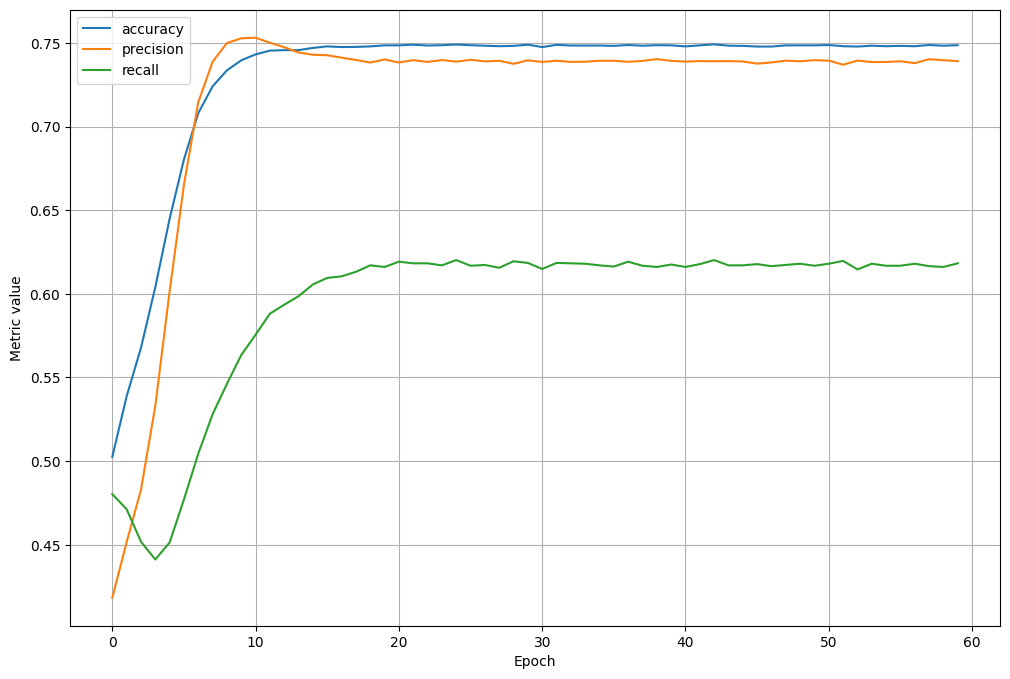

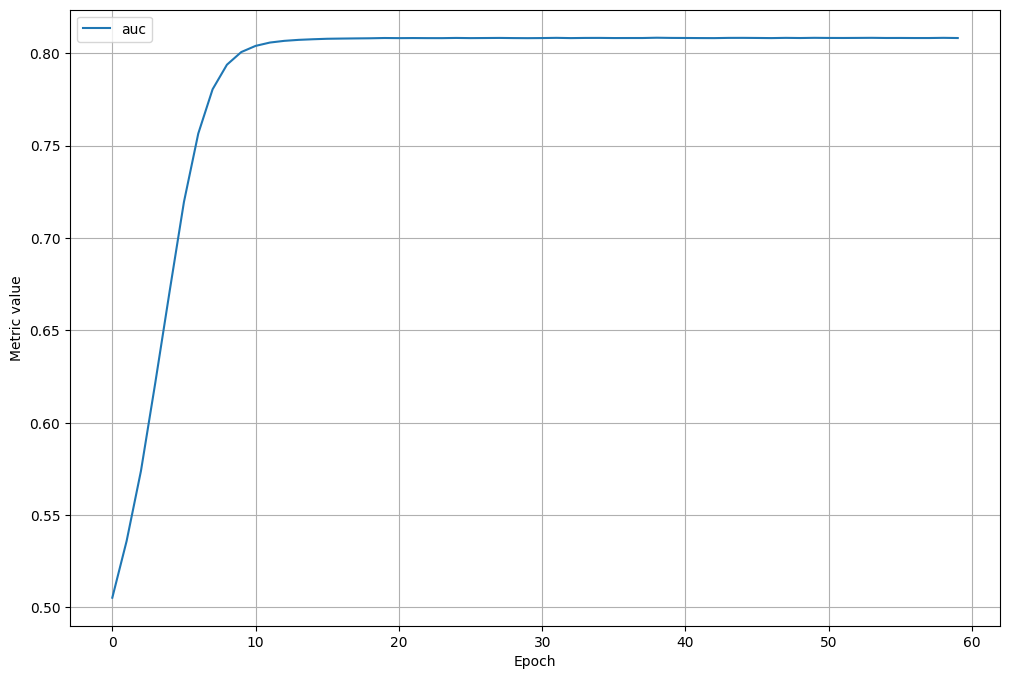

In [299]:
settings_all_features = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5,
    input_features=all_input_features,
)

# Modify the following definition of METRICS to generate
# not only accuracy and precision, but also recall:
metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy',
        threshold=settings_all_features.classification_threshold,
    ),
    keras.metrics.Precision(
        name='precision',
        thresholds=settings_all_features.classification_threshold,
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings_all_features.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
plot_experiment_metrics(experiment_all_features, ['auc'])

In [300]:
test_metrics_all_features = evaluate_experiment(
    experiment_all_features, test_features, test_labels
)
compare_train_test(experiment_all_features, test_metrics_all_features)

Comparing metrics between train and test:
------
Train loss: 0.5288
Test loss:  0.5376
------
Train accuracy: 0.7486
Test accuracy:  0.7447
------
Train precision: 0.7391
Test precision:  0.7171
------
Train recall: 0.6182
Test recall:  0.6326
------
Train auc: 0.8083
Test auc:  0.7990


In [301]:
#@title Define function to compare experiments
from matplotlib.lines import Line2D

def compare_experiment(experiments: list[Experiment],
                       metrics_of_interest: list[str],
                       test_dataset: pd.DataFrame,
                       test_labels: np.array):
  # Make sure that we have all the data we need.
  for metric in metrics_of_interest:
    for experiment in experiments:
      if metric not in experiment.metrics_history:
        raise ValueError(f'Metric {metric} not available for experiment {experiment.name}')

  fig = plt.figure(figsize=(12, 12))
  ax = fig.add_subplot(2, 1, 1)

  colors = [f'C{i}' for i in range(len(experiments))]
  markers = ['.', '*', 'd', 's', 'p', 'x']
  marker_size = 10

  ax.set_title('Train metrics')
  for i, metric in enumerate(metrics_of_interest):
    for j, experiment in enumerate(experiments):
      plt.plot(experiment.epochs, experiment.metrics_history[metric], markevery=4,
               marker=markers[i], markersize=marker_size, color=colors[j])

  # Add custom legend to show what the colors and markers mean
  legend_handles = []
  for i, metric in enumerate(metrics_of_interest):
    legend_handles.append(Line2D([0], [0], label=metric, marker=markers[i],
                                 markersize=marker_size, c='k'))
  for i, experiment in enumerate(experiments):
    legend_handles.append(Line2D([0], [0], label=experiment.name, color=colors[i]))

  ax.set_xlabel("Epoch")
  ax.set_ylabel("Metric value")
  ax.grid()
  ax.legend(handles=legend_handles)

  ax = fig.add_subplot(2, 1, 2)
  spacing = 0.3
  n_bars = len(experiments)
  bar_width = (1 - spacing)/n_bars
  for i, experiment in enumerate(experiments):
    test_metrics = evaluate_experiment(experiment, test_dataset, test_labels)
    x = np.arange(len(metrics_of_interest)) + bar_width * (i + 1/2 - n_bars/2)
    ax.bar(x, [test_metrics[metric] for metric in metrics_of_interest], width=bar_width, label=experiment.name)
  ax.set_xticks(np.arange(len(metrics_of_interest)), metrics_of_interest)

  ax.set_title('Test metrics')
  ax.set_ylabel('Metric value')
  ax.set_axisbelow(True) # Put the grid behind the bars
  ax.grid()
  ax.legend()

print('Defined function to compare experiments.')

Defined function to compare experiments.


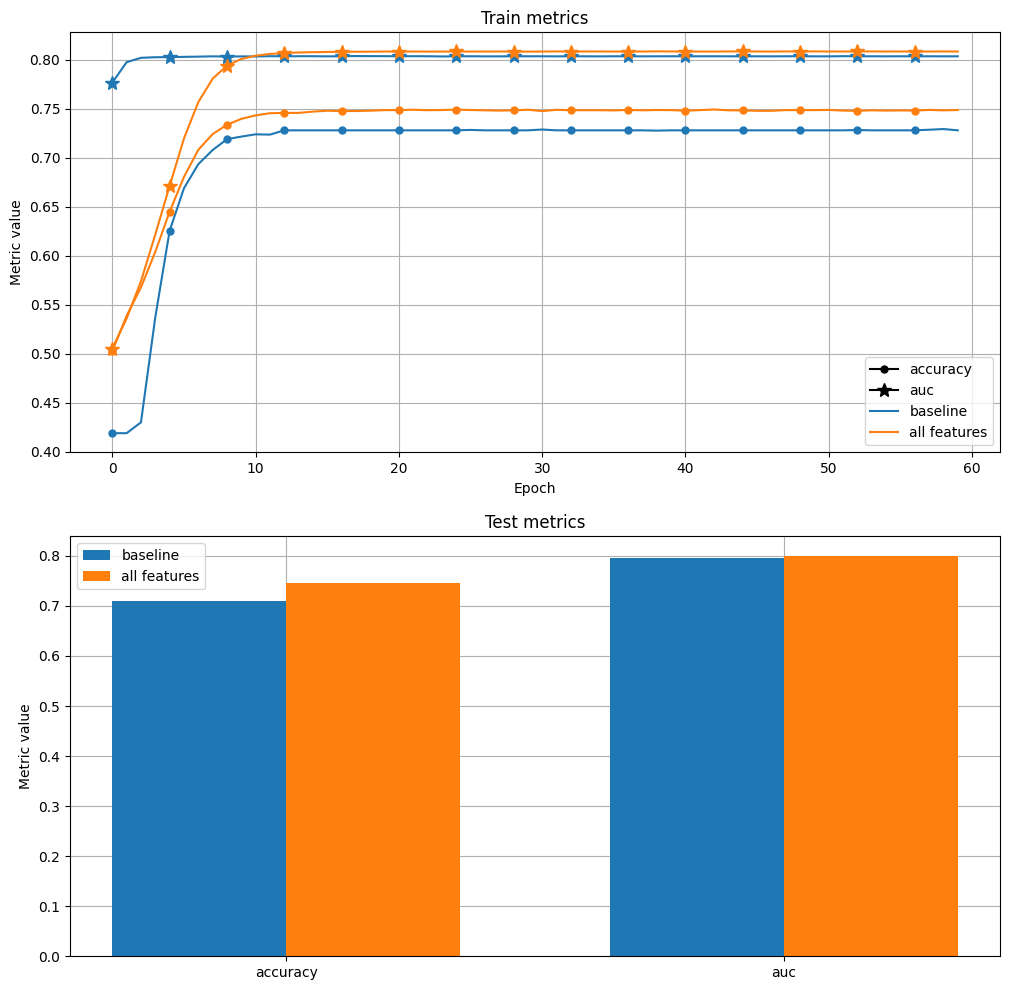

In [302]:
compare_experiment([experiment, experiment_all_features],
                   ['accuracy', 'auc'],
                   test_features, test_labels)

## 3. Building and Training the more advanced Neural Network on HRV 

Now that we have our data fully processed and split into training and testing datasets, we can begin building a neural network to solve this classification problem. Using keras, we will define a simple neural network with one hidden layer. Since this is a categorical classification problem, we will use a softmax activation function in the final layer of our network and a categorical_crossentropy loss during our training phase.

In [ ]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

path = './'
sampling_rate=100


# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id', nrows=nrows)
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
Y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
Y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

## Analyse the data

In [3]:
print(X_train)
print(Y_train)

[[[-1.190e-01 -5.500e-02  6.400e-02 ... -2.600e-02 -3.900e-02 -7.900e-02]
  [-1.160e-01 -5.100e-02  6.500e-02 ... -3.100e-02 -3.400e-02 -7.400e-02]
  [-1.200e-01 -4.400e-02  7.600e-02 ... -2.800e-02 -2.900e-02 -6.900e-02]
  ...
  [ 6.900e-02  0.000e+00 -6.900e-02 ...  2.400e-02 -4.100e-02 -5.800e-02]
  [ 8.600e-02  4.000e-03 -8.100e-02 ...  2.420e-01 -4.600e-02 -9.800e-02]
  [ 2.200e-02 -3.100e-02 -5.400e-02 ...  1.430e-01 -3.500e-02 -1.200e-01]]

 [[ 4.000e-03  1.380e-01  1.340e-01 ...  1.920e-01  8.300e-02  8.800e-02]
  [-2.000e-02  1.160e-01  1.360e-01 ...  1.560e-01  5.700e-02  6.300e-02]
  [-5.300e-02  9.200e-02  1.450e-01 ...  1.070e-01  1.300e-02  2.200e-02]
  ...
  [ 1.210e-01  3.980e-01  2.770e-01 ... -1.065e+00 -4.920e-01 -1.560e-01]
  [-3.260e-01  5.700e-02  3.830e-01 ... -2.800e-01 -1.750e-01 -7.100e-02]
  [-3.480e-01 -5.600e-02  2.920e-01 ... -3.080e-01 -2.310e-01 -1.450e-01]]

 [[-2.900e-02 -7.900e-02 -4.900e-02 ... -1.030e-01 -7.600e-02 -6.600e-02]
  [-3.500e-02 -7.000e-

In [ ]:
print(X_test)
print(Y_test)

[[[-0.145 -0.097  0.049 ... -0.452 -0.269 -0.032]
  [-0.115 -0.083  0.032 ... -0.339 -0.246 -0.041]
  [-0.064 -0.06   0.005 ... -0.188 -0.199 -0.04 ]
  ...
  [ 0.23   0.292  0.063 ...  0.443  0.362  0.222]
  [ 0.251  0.319  0.067 ...  0.498  0.405  0.261]
  [ 0.338  0.361  0.023 ...  0.515  0.447  0.299]]

 [[ 0.182  0.196  0.013 ...  0.413  0.279  0.284]
  [ 0.23   0.309  0.079 ...  0.524  0.4    0.402]
  [ 0.125 -0.092 -0.217 ... -0.002  0.022  0.181]
  ...
  [-0.076 -0.085 -0.009 ... -0.02  -0.01   0.032]
  [-0.048 -0.067 -0.019 ...  0.007  0.002  0.008]
  [-0.04  -0.053 -0.013 ...  0.032  0.022  0.015]]

 [[ 0.036  0.025 -0.011 ...  0.082  0.067 -0.014]
  [ 0.054  0.044 -0.01  ...  0.11   0.091  0.003]
  [ 0.095  0.09  -0.005 ...  0.143  0.123  0.035]
  ...
  [-0.261 -0.018  0.242 ... -0.039 -0.066 -0.082]
  [-0.049 -0.039  0.01  ... -0.043 -0.064 -0.2  ]
  [ 0.071 -0.047 -0.118 ... -0.049 -0.067 -0.082]]]
ecg_id
9     [NORM]
38    [NORM]
40    [NORM]
Name: diagnostic_superclass, d

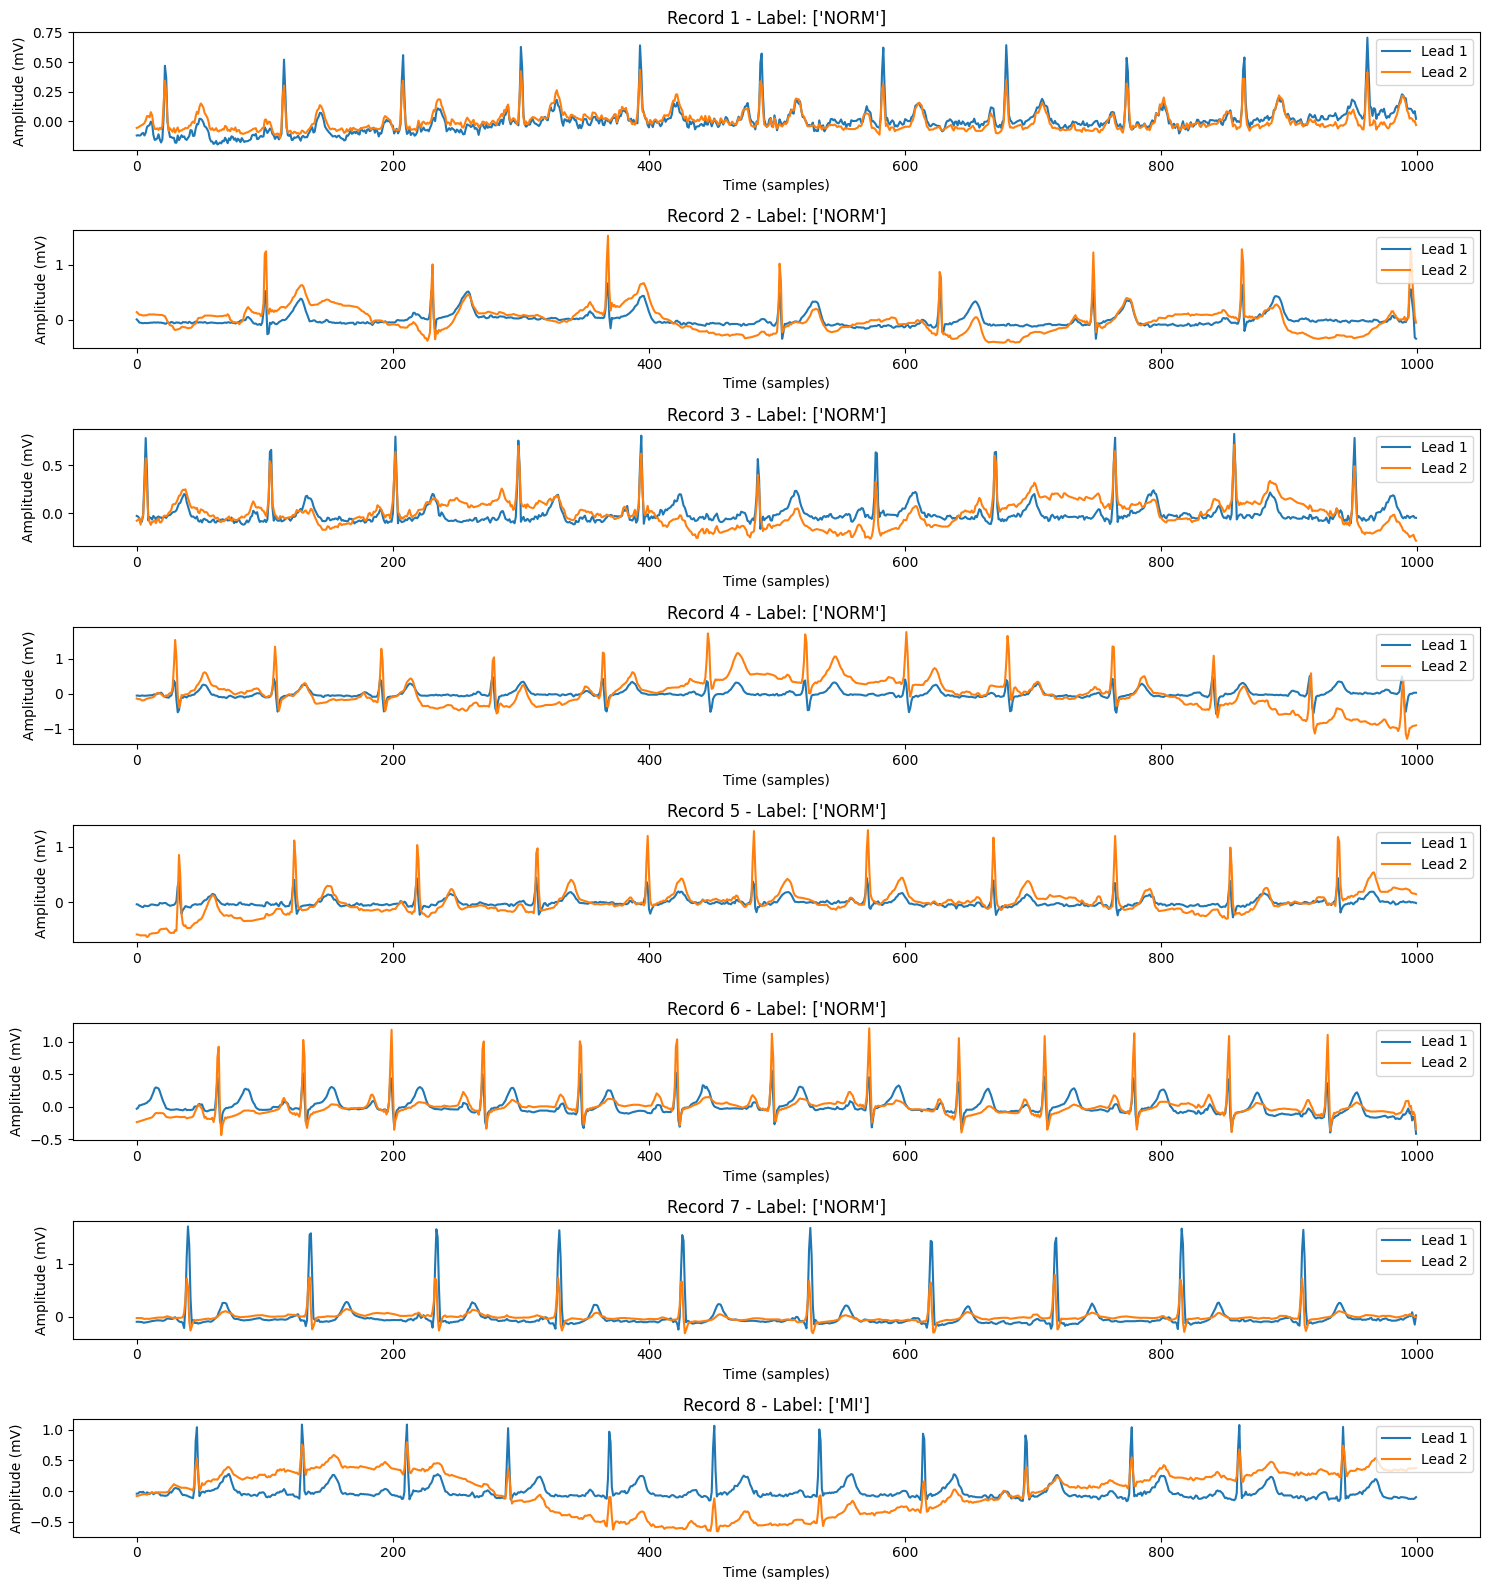

In [ ]:
num_records = 8
num_leads = 2 # maximal is 12

plt.figure(figsize=(15, num_records * 2))
for i in range(num_records):
    plt.subplot(num_records, 1, i + 1)
    for j in range(num_leads):  # Loop through each lead
        plt.plot(X_train[i][:, j], label=f'Lead {j+1}')
    plt.title(f'Record {i+1} - Label: {Y_train.iloc[i]}')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude (mV)')
    plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

## Step 1: Preprocess the Data

### Encoding Labels
Use one-hot encoding for the labels:

In [4]:
# Flatten lists to single string labels
Y_train = Y_train.apply(lambda x: x[0] if x else 'UNKNOWN')
Y_test = Y_test.apply(lambda x: x[0] if x else 'UNKNOWN')

In [5]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Convert Y_train and Y_test into numerical labels
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_test_encoded = label_encoder.transform(Y_test)

In [182]:
# Convert to one-hot encoding
Y_train_onehot = np.eye(len(np.unique(Y_train_encoded)))[Y_train_encoded]
Y_test_onehot = np.eye(len(np.unique(Y_test_encoded)))[Y_test_encoded]

### Normalizing Input Data

In [183]:
from sklearn.preprocessing import StandardScaler

# Reshape X_train and X_test to 2D for scaling if necessary
scaler = StandardScaler()
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # Flatten for scaling
X_train_scaled = scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)

X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])  # Flatten for scaling
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape)

### Step 2: Build the Neural Network Model

In [ ]:
# Initialize the model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(Y_train_onehot.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Step 3: Train the Model


In [185]:
# Train the model
history = model.fit(X_train_scaled, Y_train_onehot, epochs=30, batch_size=32, 
                    validation_data=(X_test_scaled, Y_test_onehot))

Epoch 1/30
28/28 [==============================] - 34s 1s/step - loss: 1.5919 - accuracy: 0.3823 - val_loss: 1.3984 - val_accuracy: 0.4806
Epoch 2/30
28/28 [==============================] - 30s 1s/step - loss: 1.3069 - accuracy: 0.5189 - val_loss: 1.3579 - val_accuracy: 0.4806
Epoch 3/30
28/28 [==============================] - 39s 1s/step - loss: 1.3019 - accuracy: 0.5121 - val_loss: 1.3448 - val_accuracy: 0.4884
Epoch 4/30
28/28 [==============================] - 37s 1s/step - loss: 1.2467 - accuracy: 0.5396 - val_loss: 1.3178 - val_accuracy: 0.5039
Epoch 5/30
28/28 [==============================] - 34s 1s/step - loss: 1.2080 - accuracy: 0.5431 - val_loss: 1.3112 - val_accuracy: 0.4961
Epoch 6/30
28/28 [==============================] - 36s 1s/step - loss: 1.1945 - accuracy: 0.5591 - val_loss: 1.3140 - val_accuracy: 0.5271
Epoch 7/30
28/28 [==============================] - 33s 1s/step - loss: 1.1504 - accuracy: 0.5614 - val_loss: 1.3147 - val_accuracy: 0.5194
Epoch 8/30
28/28 [==

### Step 4: Evaluate the Model


In [186]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, Y_test_onehot)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

5/5 [==============================] - 1s 241ms/step - loss: 1.3338 - accuracy: 0.5891
Test Loss: 1.3338496685028076
Test Accuracy: 0.5891472697257996


### Step 5: Make Predictions


In [187]:
# Predict classes
predictions = model.predict(X_test_scaled)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

5/5 [==============================] - 2s 220ms/step


In [189]:
predicted_labels

array(['NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM',
       'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM',
       'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'CD', 'STTC', 'CD',
       'NORM', 'STTC', 'NORM', 'CD', 'NORM', 'NORM', 'NORM', 'NORM',
       'NORM', 'STTC', 'NORM', 'NORM', 'STTC', 'NORM', 'STTC', 'CD',
       'STTC', 'NORM', 'STTC', 'UNKNOWN', 'CD', 'NORM', 'NORM', 'NORM',
       'NORM', 'CD', 'STTC', 'NORM', 'STTC', 'NORM', 'NORM', 'NORM',
       'NORM', 'NORM', 'NORM', 'STTC', 'CD', 'MI', 'NORM', 'NORM', 'STTC',
       'NORM', 'UNKNOWN', 'NORM', 'STTC', 'CD', 'STTC', 'NORM', 'NORM',
       'STTC', 'CD', 'NORM', 'STTC', 'MI', 'NORM', 'NORM', 'UNKNOWN',
       'NORM', 'CD', 'NORM', 'NORM', 'STTC', 'NORM', 'STTC', 'CD', 'NORM',
       'STTC', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM', 'NORM',
       'MI', 'NORM', 'NORM', 'NORM', 'STTC', 'NORM', 'NORM', 'CD', 'NORM',
       'NORM', 'NORM', 'CD', 'NORM', 'STTC', 'NORM', 'NORM', 'NORM

Optional: Model Tuning and Optimization

Adjust Hyperparameters: Experiment with the number of layers, neurons, dropout rates, etc.

Cross-Validation: Consider cross-validating for more reliable performance metrics.

Try Other Models: Consider 1D CNN layers, which often perform well on time-series data like HRV.

### 4. Improving Results - A Binary Classification Problem

Although we achieved promising results, we still have a fairly large error. This could be because it is very difficult to distinguish between the different severity levels of heart disease (classes 1 - 4). Let's simplify the problem by converting the data to a binary classification problem - heart disease or no heart disease.

In [26]:
# convert into binary classification problem - heart disease or no heart disease
Y_train_binary = y_train.copy()
Y_test_binary = y_test.copy()

Y_train_binary[Y_train_binary > 0] = 1
Y_test_binary[Y_test_binary > 0] = 1

print (Y_train_binary[:20])

[0 0 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1]


In [27]:
# define a new keras model for binary classification
def create_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(8, input_dim=13, kernel_initializer='normal', activation='relu'))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile model
    adam = Adam(lr=0.001)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

binary_model = create_binary_model()

print(binary_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8)                 112       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 36        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
# fit the binary model on the training data
binary_model.fit(X_train, Y_train_binary, epochs=100, batch_size=10, verbose = 1)

Epoch 1/100
237/237 [==============================] - 1s 3ms/step - loss: 0.7204 - accuracy: 0.5612
Epoch 2/100
237/237 [==============================] - 0s 354us/step - loss: 0.6801 - accuracy: 0.5781
Epoch 3/100
237/237 [==============================] - 0s 388us/step - loss: 0.6782 - accuracy: 0.6118
Epoch 4/100
237/237 [==============================] - 0s 219us/step - loss: 0.6739 - accuracy: 0.6371
Epoch 5/100
237/237 [==============================] - 0s 219us/step - loss: 0.6405 - accuracy: 0.6287
Epoch 6/100
237/237 [==============================] - 0s 186us/step - loss: 0.6310 - accuracy: 0.6456
Epoch 7/100
237/237 [==============================] - 0s 202us/step - loss: 0.6023 - accuracy: 0.7595
Epoch 8/100
237/237 [==============================] - 0s 202us/step - loss: 0.5834 - accuracy: 0.7553
Epoch 9/100
237/237 [==============================] - 0s 219us/step - loss: 0.5740 - accuracy: 0.7131
Epoch 10/100
237/237 [==============================] - 0s 186us/step - los

237/237 [==============================] - 0s 321us/step - loss: 0.3584 - accuracy: 0.8692
Epoch 80/100
237/237 [==============================] - 0s 219us/step - loss: 0.3630 - accuracy: 0.8439
Epoch 81/100
237/237 [==============================] - 0s 202us/step - loss: 0.3670 - accuracy: 0.8439
Epoch 82/100
237/237 [==============================] - 0s 202us/step - loss: 0.3623 - accuracy: 0.8439
Epoch 83/100
237/237 [==============================] - 0s 186us/step - loss: 0.3584 - accuracy: 0.8608
Epoch 84/100
237/237 [==============================] - 0s 202us/step - loss: 0.3776 - accuracy: 0.8312
Epoch 85/100
237/237 [==============================] - 0s 186us/step - loss: 0.3639 - accuracy: 0.8608
Epoch 86/100
237/237 [==============================] - 0s 193us/step - loss: 0.3618 - accuracy: 0.8397
Epoch 87/100
237/237 [==============================] - 0s 194us/step - loss: 0.3549 - accuracy: 0.8692
Epoch 88/100
237/237 [==============================] - 0s 177us/step - loss:

### 5. Results and Metrics

The accuracy results we have been seeing are for the training data, but what about the testing dataset? If our model's cannot generalize to data that wasn't used to train them, they won't provide any utility. 

Let's test the performance of both our categorical model and binary model.  To do this, we will make predictions on the training dataset and calculate performance metrics using Sklearn.

In [29]:
# generate classification report using predictions for categorical model
from sklearn.metrics import classification_report, accuracy_score

categorical_pred = np.argmax(model.predict(X_test), axis=1)

print('Results for Categorical Model')
print(accuracy_score(y_test, categorical_pred))
print(classification_report(y_test, categorical_pred))

Results for Categorical Model
0.6666666666666666
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        36
           1       0.33      0.09      0.14        11
           2       0.00      0.00      0.00         6
           3       0.35      1.00      0.52         6
           4       0.00      0.00      0.00         1

    accuracy                           0.67        60
   macro avg       0.30      0.40      0.31        60
weighted avg       0.59      0.67      0.60        60



E:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
# generate classification report using predictions for binary model 
binary_pred = np.round(binary_model.predict(X_test)).astype(int)

print('Results for Binary Model')
print(accuracy_score(Y_test_binary, binary_pred))
print(classification_report(Y_test_binary, binary_pred))

Results for Binary Model
0.7833333333333333
              precision    recall  f1-score   support

           0       0.87      0.75      0.81        36
           1       0.69      0.83      0.75        24

    accuracy                           0.78        60
   macro avg       0.78      0.79      0.78        60
weighted avg       0.80      0.78      0.79        60

